# Word2Vec

原理：https://www.jianshu.com/p/471d9bfbd72f

数学基础：https://www.cnblogs.com/peghoty/p/3857839.html

> - 如果是用一个词语作为输入，来预测它周围的上下文，那这个模型叫做 __Skip-gram 模型__
> - 而如果是拿一个词语的上下文作为输入，来预测这个词语本身，则是 __CBOW 模型__

## Skip-gram和CBOW的通用形式:
__用当前词 x 预测它的下一个词 y__

> - input: 输入词的one-hot encoder
> - output: 输出词的one-hot encoder

![image](s.png)


## Skip-gram
__当 y 有多个词时__
> - input: 输入词的one-hot encoder
> - multi-output: 输出词的one-hot encoder

![image](skip-gram.png)

## CBOW
__当 x 有多个词时__
> - multi-input: 输入词的one-hot encoder
> - output: 输出词的one-hot encoder

![image](CBOW.png)

## Hierarchical Softmax
__层次softmax的核心内容是哈夫曼树（Huffman Tree），树的核心概念是 出现概率越高的符号使用较短的编码（层次越浅），出现概率低的符号则使用较长的编码（层次越深)。__

![image](Hierarchical_softmax.png)

## 负采样
__任何采样算法都应该保证频次越高的样本越容易被采样出来。__

In [2]:
# see http://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [3]:
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()

split_ind = (int)(len(text) * 0.8)

# By deriving a set from `raw_text`, we deduplicate the array
vocab = set(text)
vocab_size = len(vocab)
print('vocab_size:', vocab_size)

w2i = {w: i for i, w in enumerate(vocab)}
i2w = {i: w for i, w in enumerate(vocab)}

vocab_size: 49


In [4]:
print(w2i)

{'about': 0, 'of': 1, 'beings': 2, 'rules': 3, 'computers.': 4, 'In': 5, 'effect,': 6, 'programs': 7, 'Computational': 8, 'computational': 9, 'data.': 10, 'to': 11, 'conjure': 12, 'We': 13, 'spirits': 14, 'things': 15, 'computer': 16, 'is': 17, 'manipulate': 18, 'with': 19, 'People': 20, 'evolve,': 21, 'study': 22, 'other': 23, 'idea': 24, 'process.': 25, 'evolution': 26, 'directed': 27, 'pattern': 28, 'processes': 29, 'spells.': 30, 'program.': 31, 'inhabit': 32, 'we': 33, 'by': 34, 'our': 35, 'abstract': 36, 'create': 37, 'they': 38, 'the': 39, 'As': 40, 'a': 41, 'process': 42, 'processes.': 43, 'that': 44, 'The': 45, 'are': 46, 'direct': 47, 'called': 48}


In [5]:
i2w

{0: 'about',
 1: 'of',
 2: 'beings',
 3: 'rules',
 4: 'computers.',
 5: 'In',
 6: 'effect,',
 7: 'programs',
 8: 'Computational',
 9: 'computational',
 10: 'data.',
 11: 'to',
 12: 'conjure',
 13: 'We',
 14: 'spirits',
 15: 'things',
 16: 'computer',
 17: 'is',
 18: 'manipulate',
 19: 'with',
 20: 'People',
 21: 'evolve,',
 22: 'study',
 23: 'other',
 24: 'idea',
 25: 'process.',
 26: 'evolution',
 27: 'directed',
 28: 'pattern',
 29: 'processes',
 30: 'spells.',
 31: 'program.',
 32: 'inhabit',
 33: 'we',
 34: 'by',
 35: 'our',
 36: 'abstract',
 37: 'create',
 38: 'they',
 39: 'the',
 40: 'As',
 41: 'a',
 42: 'process',
 43: 'processes.',
 44: 'that',
 45: 'The',
 46: 'are',
 47: 'direct',
 48: 'called'}

In [3]:
# context window size is two
def create_cbow_dataset(text):
    data = []
    for i in range(2, len(text) - 2):
        context = [text[i - 2], text[i - 1],
                   text[i + 1], text[i + 2]]
        target = text[i]
        data.append((context, target))
    return data

def create_skipgram_dataset(text):
    import random
    data = []
    for i in range(2, len(text) - 2):
        data.append((text[i], text[i-2], 1))
        data.append((text[i], text[i-1], 1))
        data.append((text[i], text[i+1], 1))
        data.append((text[i], text[i+2], 1))
        # negative sampling
        for _ in range(4):
            if random.random() < 0.5 or i >= len(text) - 3:
                rand_id = random.randint(0, i-1)
            else:
                rand_id = random.randint(i+3, len(text)-1)
            data.append((text[i], text[rand_id], 0))
    return data

cbow_train = create_cbow_dataset(text)
skipgram_train = create_skipgram_dataset(text)
print('cbow sample', cbow_train[0])
print('skipgram sample', skipgram_train[0])

cbow sample (['We', 'are', 'to', 'study'], 'about')
skipgram sample ('about', 'We', 1)


In [4]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embd_size, context_size, hidden_size):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embd_size)
        self.linear1 = nn.Linear(2*context_size*embd_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, inputs):
        embedded = self.embeddings(inputs).view((1, -1))
        hid = F.relu(self.linear1(embedded))
        out = self.linear2(hid)
        log_probs = F.log_softmax(out)
        return log_probs

class SkipGram(nn.Module):
    def __init__(self, vocab_size, embd_size):
        super(SkipGram, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embd_size)
    
    def forward(self, focus, context):
        embed_focus = self.embeddings(focus).view((1, -1))
        embed_ctx = self.embeddings(context).view((1, -1))
        score = torch.mm(embed_focus, torch.t(embed_ctx))
        log_probs = F.logsigmoid(score)
    
        return log_probs

In [9]:
embd_size = 100
learning_rate = 0.001
n_epoch = 30

def train_cbow():
    hidden_size = 64
    losses = []
    loss_fn = nn.NLLLoss()
    model = CBOW(vocab_size, embd_size, CONTEXT_SIZE, hidden_size)
    print(model)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    for epoch in range(n_epoch):
        total_loss = 0
        for context, target in cbow_train:
            ctx_idxs = [w2i[w] for w in context]
            ctx_var = Variable(torch.LongTensor(ctx_idxs))

            model.zero_grad()
            log_probs = model(ctx_var)

            loss = loss_fn(log_probs, Variable(torch.LongTensor([w2i[target]])))

            loss.backward()
            optimizer.step()
            total_loss += loss.data
        losses.append(total_loss)
    return model, losses

def train_skipgram():
    losses = []
    loss_fn = nn.MSELoss()
    model = SkipGram(vocab_size, embd_size)
    print(model)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    for epoch in range(n_epoch):
        total_loss = .0
        for in_w, out_w, target in skipgram_train:
            in_w_var = Variable(torch.LongTensor([w2i[in_w]]))
            out_w_var = Variable(torch.LongTensor([w2i[out_w]]))
            
            model.zero_grad()
            log_probs = model(in_w_var, out_w_var)
            loss = loss_fn(log_probs[0], Variable(torch.Tensor([target])))
            
            loss.backward()
            optimizer.step()

            total_loss += loss.data
        losses.append(total_loss)
    return model, losses
    
cbow_model, cbow_losses = train_cbow()
sg_model, sg_losses = train_skipgram()

CBOW(
  (embeddings): Embedding(49, 100)
  (linear1): Linear(in_features=400, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=49, bias=True)
)


/Users/rayest/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


SkipGram(
  (embeddings): Embedding(49, 100)
)


In [19]:
# test
# You have to use other dataset for test, but in this case I use training data because this dataset is too small
def test_cbow(test_data, model):
    print('====Test CBOW===')
    correct_ct = 0
    for ctx, target in test_data:
        ctx_idxs = [w2i[w] for w in ctx]
        ctx_var = Variable(torch.LongTensor(ctx_idxs))

        model.zero_grad()
        log_probs = model(ctx_var)
        _, predicted = torch.max(log_probs.data, 1)
        #print(i2w)
        predicted_word = i2w[int(predicted[0].numpy())]
        #print('predicted:', predicted_word)
        #print('label    :', target)
        if predicted_word == target:
            correct_ct += 1
            
    print('Accuracy: {:.1f}% ({:d}/{:d})'.format(correct_ct/len(test_data)*100, correct_ct, len(test_data)))

def test_skipgram(test_data, model):
    print('====Test SkipGram===')
    correct_ct = 0
    for in_w, out_w, target in test_data:
        in_w_var = Variable(torch.LongTensor([w2i[in_w]]))
        out_w_var = Variable(torch.LongTensor([w2i[out_w]]))

        model.zero_grad()
        log_probs = model(in_w_var, out_w_var)
        _, predicted = torch.max(log_probs.data, 1)
        predicted = predicted[0]
        if predicted == target:
            correct_ct += 1

    print('Accuracy: {:.1f}% ({:d}/{:d})'.format(correct_ct/len(test_data)*100, correct_ct, len(test_data)))

test_cbow(cbow_train, cbow_model)
print('------')
test_skipgram(skipgram_train, sg_model)

====Test CBOW===
Accuracy: 94.8% (55/58)
------
====Test SkipGram===
Accuracy: 50.0% (232/464)


/Users/rayest/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


<Figure size 432x288 with 0 Axes>

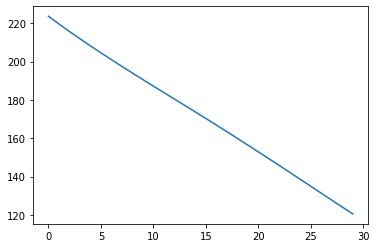

<Figure size 432x288 with 0 Axes>

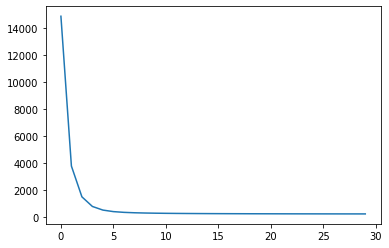

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def showPlot(points, title):
    plt.figure()
    fig, ax = plt.subplots()
    plt.plot(points)

showPlot(cbow_losses, 'CBOW Losses')
showPlot(sg_losses, 'SkipGram Losses')